# # Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from datetime import datetime
from datetime import timedelta
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

%matplotlib inline

debugtoggle = True

In [2]:
# Load .env enviroment variables
load_dotenv()

True

# Part 1: Personal Financial Planner

## Collect Crypto Prices Using the requests Library

Set current amount of crypto assets

In [3]:
BTC=1.2

In [4]:
ETH=5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
btc_url

'https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD'

In [7]:
eth_url

'https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD'

In [8]:
# Fetch current BTC price
response_data=requests.get(btc_url)
data = response_data.json()
my_btc_value=data['data']['1']['quotes']['CAD']['price']

In [9]:
print(f"The current value of your {BTC} BTC is ${my_btc_value:0.2f}")

The current value of your 1.2 BTC is $57484.33


In [10]:
# Fetch current BTC price
eth_response_data=requests.get(eth_url)
data = eth_response_data.json()
my_eth_value=data['data']['1027']['quotes']['CAD']['price']
my_eth_value

4321.7162

In [11]:
print(f"The current value of your {ETH} ETH is ${my_eth_value:0.2f}")

The current value of your 5.3 ETH is $4321.72


## Collect Investments Data Using Alpaca: SPY (stocks) and AGG (bonds)

In [12]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [13]:
# Set Alpaca API key and secret
api_key=os.getenv("alpaca_api_key")

# Create the Alpaca API object
api_secret_key=os.getenv("alpaca_secret_key")

In [14]:
api_secret_key

'fGvp3ZhuBy8cdSHtMv3JKoQcjTfDlLQDj14kNPQL'

In [16]:
# Format current date as ISO format
start_date = "2022-03-21"
end_date = "2022-03-21"

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
api = REST(api_key , api_secret_key, api_version='v2')
stock_and_bond_prices = api.get_bars(tickers, TimeFrame.Day, start_date, end_date, adjustment='raw').df
stock_and_bond_prices.index = stock_and_bond_prices.index.date

# Preview DataFrame
if (debugtoggle):
    print(f'{stock_and_bond_prices.head()}')
    #print(f'here {stock_and_bond_prices[["close","symbol"]]}')

              open     high       low   close    volume  trade_count  \
2022-03-21  107.58  107.649  106.9841  107.04   7583668        27316   
2022-03-21  444.45  446.460  440.6800  444.30  85377983       912432   

                  vwap symbol  
2022-03-21  107.310151    AGG  
2022-03-21  443.796432    SPY  


In [17]:
# Pick AGG and SPY close prices
stock_and_bond_prices = stock_and_bond_prices[["close","symbol"]]
#rslt_df = dataframe[dataframe['Percentage'] > 80]
agg_close_price = float(stock_and_bond_prices[stock_and_bond_prices['symbol']=="AGG"].iloc[0]["close"])
spy_close_price = float(stock_and_bond_prices[stock_and_bond_prices['symbol']=="SPY"].iloc[0]["close"])
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.04
Current SPY closing price: $444.3


In [18]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:,.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:,.2f}")

The current value of your 50 SPY shares is $22,215.00
The current value of your 200 AGG shares is $21,408.00


## Savings Health Analysis

In [19]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
shares_value = my_spy_value+my_agg_value
crypto_value = my_btc_value+my_eth_value
savings_data = [shares_value, crypto_value]

# Create savings DataFrame
df_savings = pd.DataFrame(savings_data, columns = ['Amount'], index = ['Shares','Crypto']) 


# Display savings DataFrame
display(df_savings)

,Amount
Shares,43623.0000
Crypto,61806.0442


<AxesSubplot:title={'center':'Personal Savings'}, ylabel='Amount'>

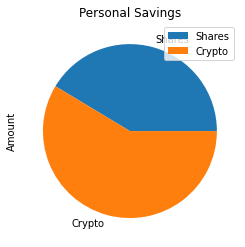

In [20]:
# Plot savings pie chart
df_savings.plot.pie(y='Amount',title='Personal Savings')

In [21]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = shares_value + crypto_value

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in your savings fund')
elif total_savings == emergency_fund: 
    print('Congratulations! You have reached your financial goal')
else:
    diff_efund == (emergency_fund - total_savings)
    print(f"Keep up the good work... You're ${diff_efund} away from reaching your financial goal")

Congratulations! You have enough money in your savings fund


# Part 2 - Retirement Planning

## Monte Carlo Simulation

In [22]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen

##### Commenting Deprecated way to pass the start and end dates with the API
#start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
#end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

#Updated way to pass the dates with the API
start_date = "2017-03-20"
end_date = "2022-03-20"

In [23]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
api = REST(api_key , api_secret_key, api_version='v2')
df_stock_data = api.get_bars(tickers, TimeFrame.Day, start_date, end_date, adjustment='raw').df
df_stock_data.index=df_stock_data.index.date
df_stock_data=df_stock_data[['close', 'symbol']]

# Display sample data
df_stock_data.head()

,close,symbol
2017-03-20,108.05,AGG
2017-03-21,108.27,AGG
2017-03-22,108.42,AGG
2017-03-23,108.45,AGG
2017-03-24,108.36,AGG


In [24]:
#Manipulating the DF to work with the MCSimulation function
pivottable = pd.pivot_table(df_stock_data, values='close', index=df_stock_data.index, columns=['symbol'])
ticker_name = list(pivottable.columns)
ticker_name = [(x,'close') for x in pivottable.columns]
micolumns = pd.MultiIndex.from_tuples(ticker_name)
pivottable.columns = micolumns
pivottable

,AGG,SPY
,close,close
2017-03-20,108.05,236.77
2017-03-21,108.27,233.73
2017-03-22,108.42,234.28
2017-03-23,108.45,234.03
2017-03-24,108.36,233.86
...,...,...
2022-03-14,107.36,417.00
2022-03-15,107.60,426.17
2022-03-16,107.68,435.55


In [25]:
# Configuring a Monte Carlo simulation to forecast thirty years cumulative returns

# Assum a traditional 40/60 portfolio using the SPY and AGG tickers to represent 
# the 60% stocks (SPY) and 40% bonds (AGG) composition of the portfolio. 

MC_thirtyyears = MCSimulation(
    portfolio_data = pivottable,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [27]:
# Printing the simulation input data
print(f" Printing the simulation input data \n\n {MC_thirtyyears.portfolio_data.head()}")

 Printing the simulation input data 

                AGG                  SPY             
             close daily_return   close daily_return
2017-03-20  108.05          NaN  236.77          NaN
2017-03-21  108.27     0.002036  233.73    -0.012839
2017-03-22  108.42     0.001385  234.28     0.002353
2017-03-23  108.45     0.000277  234.03    -0.001067
2017-03-24  108.36    -0.000830  233.86    -0.000726


In [28]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vanessateranm/Desktop/test/UTOR-VIRT-FIN-PT-02-2022-U-LOL-main/Homeworks/05-APIs/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010269,1.005066,0.991632,1.005692,1.012452,1.001114,1.002542,0.993938,0.993626,1.002140,...,1.004582,1.006984,1.012110,1.007090,0.994653,0.997454,0.996374,1.001868,1.001724,0.987073
2,1.006177,1.008908,0.982788,1.016256,1.016418,0.993858,0.997461,0.997277,1.001205,0.999930,...,1.007001,1.006845,1.011524,1.018553,1.000793,1.007222,1.004693,1.001352,0.998793,0.983596
3,1.009941,1.002195,0.976134,1.008955,1.013650,0.999735,1.001008,0.995914,0.997674,1.010588,...,1.017721,1.010096,1.003478,1.028223,0.986938,1.018326,1.008767,1.001594,1.007347,0.975185
4,1.010130,1.001698,0.972973,1.002314,1.015941,0.986588,1.002212,0.992007,0.999668,1.005481,...,1.022940,1.023897,0.996519,1.025901,0.999590,1.011697,1.009891,1.004678,1.001058,0.969815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,23.412801,6.332214,9.782089,21.023196,48.230577,9.776441,8.517070,16.419932,7.744999,17.657662,...,5.651880,17.554616,6.383980,8.842271,36.876330,3.410241,17.435514,9.962617,4.999859,16.725768
7557,23.565504,6.303496,9.816478,21.111421,48.309917,9.803887,8.575277,16.437940,7.837333,17.737442,...,5.670937,17.295076,6.340315,8.837962,37.411661,3.399572,17.649872,9.988192,5.022288,16.804667
7558,23.685142,6.353876,9.783555,21.203391,48.920085,9.794434,8.567677,16.464579,7.752624,17.965516,...,5.714787,17.409869,6.364031,8.741414,37.936277,3.424870,17.751512,10.008340,4.995504,16.859209
7559,23.784175,6.430580,9.785333,21.204042,48.778927,9.611753,8.526733,16.614487,7.726352,17.915282,...,5.645272,17.557297,6.425476,8.664516,37.501291,3.453105,17.905997,9.953231,4.974353,16.832421


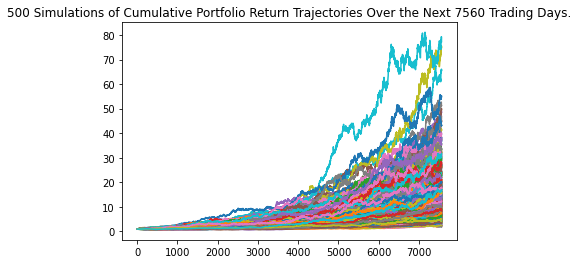

In [29]:
# Plot simulation outcomes
line_plot = MC_thirtyyears.plot_simulation()
line_plot.get_figure().savefig("MC_thirtyyear_sim_plot.png", bbox_inches="tight")

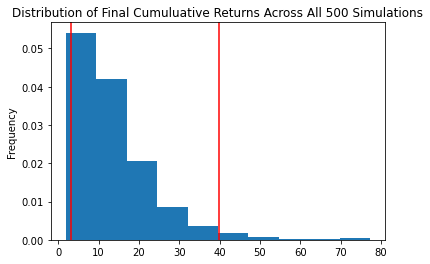

In [30]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyears.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_thirtyyear_dist_plot.png',bbox_inches='tight')

## Retiterement Analysis

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_cumulative_return = MC_thirtyyears.summarize_cumulative_return()

# Print summary statistics
print(tbl_cumulative_return)

count           500.000000
mean             13.853153
std              10.290638
min               1.884465
25%               7.020540
50%              10.814239
75%              18.105697
max              77.284720
95% CI Lower      3.072019
95% CI Upper     39.723045
Name: 7560, dtype: float64


## Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a $20,000 initial investment.

In [32]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_thirtyyears.confidence_interval.iloc[0] * initial_investment, 2)
ci_upper = round(MC_thirtyyears.confidence_interval.iloc[1] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower:,} and ${ci_upper:,}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $61,440.38 and $794,460.9


## Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a 50% increase in the initial investment.

In [33]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_thirtyyears.confidence_interval.iloc[0] * initial_investment, 2)
ci_upper = round(MC_thirtyyears.confidence_interval.iloc[1] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower:,} and ${ci_upper:,}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $92,160.57 and $1,191,691.35


# Optional Challenge - Early Retirement

## Five Years Retirement Option

In [34]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears = MCSimulation(
    portfolio_data = pivottable,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [35]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vanessateranm/Desktop/test/UTOR-VIRT-FIN-PT-02-2022-U-LOL-main/Homeworks/05-APIs/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999190,1.004696,1.010587,1.002133,0.994619,0.998360,1.002385,0.998607,1.004213,1.001686,...,1.011002,1.002961,1.015000,1.004528,1.008948,1.005204,0.992475,0.997209,1.006236,0.998843
2,1.006439,0.998469,1.010424,0.993041,0.994558,1.008086,1.012012,0.987575,1.002208,1.002978,...,1.014395,1.005811,1.006653,0.996571,1.004381,0.997659,0.991857,1.003790,0.998691,1.000176
3,0.998916,1.004620,1.014990,1.003355,1.000404,0.992304,1.022570,0.997755,1.004322,1.002563,...,1.010121,0.992817,1.009447,1.006449,1.002459,1.008582,0.970687,1.013009,0.997286,1.009236
4,1.001421,1.004611,1.013205,0.999875,0.998184,1.001732,1.025679,1.006223,1.008617,1.002643,...,1.017139,0.999879,1.013700,1.013730,1.005352,1.016403,0.966962,1.004598,0.998519,1.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.769149,1.201607,0.872776,1.002837,1.720895,1.740746,1.567757,1.894136,1.639492,1.385340,...,0.865888,1.263976,1.718558,1.769633,1.298743,1.735824,1.309542,1.816488,1.085578,1.408312
1257,1.779198,1.198672,0.870697,1.011155,1.712612,1.731080,1.562913,1.907617,1.617460,1.388817,...,0.882271,1.265461,1.726360,1.738236,1.295984,1.744228,1.305316,1.827004,1.082032,1.403294
1258,1.767017,1.196676,0.863062,1.009018,1.724288,1.741368,1.556378,1.891341,1.609796,1.398418,...,0.870083,1.267838,1.724770,1.725714,1.299739,1.735440,1.300036,1.824362,1.085631,1.409090
1259,1.766708,1.210337,0.864357,1.013081,1.754477,1.764494,1.568827,1.895797,1.618998,1.397228,...,0.864238,1.263249,1.707970,1.735455,1.289922,1.725505,1.318276,1.831593,1.082357,1.425589


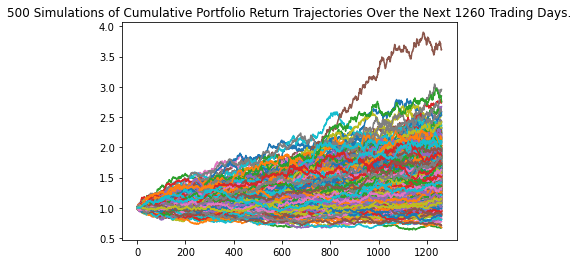

In [36]:
# Plot simulation outcomes
line_plot = MC_fiveyears.plot_simulation()
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

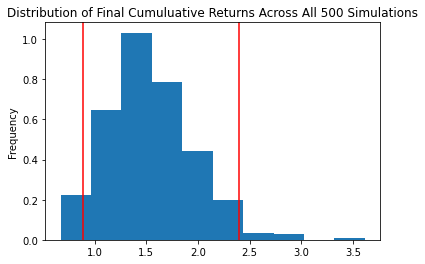

In [37]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyears.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_cumulative_return = MC_fiveyears.summarize_cumulative_return()

# Print summary statistics
print(tbl_cumulative_return)

count           500.000000
mean              1.536198
std               0.406451
min               0.670476
25%               1.245470
50%               1.503199
75%               1.778317
max               3.614273
95% CI Lower      0.886973
95% CI Upper      2.396069
Name: 1260, dtype: float64


In [39]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five = round(MC_fiveyears.confidence_interval.iloc[0] * initial_investment, 2)
ci_upper_five = round(MC_fiveyears.confidence_interval.iloc[1] * initial_investment, 2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five:,} and ${ci_upper_five:,}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $17,739.45 and $47,921.38


## Ten Years Retirement Option

In [40]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears = MCSimulation(
    portfolio_data = pivottable,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [41]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vanessateranm/Desktop/test/UTOR-VIRT-FIN-PT-02-2022-U-LOL-main/Homeworks/05-APIs/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004122,0.992754,1.004535,1.003195,0.992594,1.007461,1.000229,1.001932,1.008521,0.996262,...,1.006356,1.008044,0.999989,1.007990,0.989859,0.988903,0.991157,1.010572,0.995353,0.997267
2,1.005574,0.990833,0.999938,1.006966,0.982979,1.011974,1.004754,1.019932,1.014531,1.003604,...,1.002313,0.998642,0.999074,1.007492,0.988982,0.993153,0.995986,1.021801,0.994968,0.996357
3,0.996826,0.996738,0.996830,1.007761,0.983936,1.024030,1.012012,1.024186,1.012104,0.991383,...,1.005384,1.002499,0.987637,1.007945,0.988005,0.992152,1.005125,1.021029,1.001849,1.004237
4,0.992960,0.991963,0.992281,1.012722,0.974583,1.024055,1.001527,1.029618,1.021276,0.990569,...,1.005483,1.006446,0.980166,1.000332,0.998265,1.003177,1.006962,1.038739,1.011419,0.995253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.431497,1.735804,4.515016,2.252860,3.444177,1.381439,2.717580,2.054992,2.642915,4.580947,...,1.939315,2.223655,1.870922,1.383594,2.479319,1.870523,1.189139,2.495698,3.085852,2.178257
2517,1.421971,1.753532,4.484796,2.242714,3.465657,1.389884,2.693573,2.038281,2.641319,4.603560,...,1.936178,2.219702,1.868329,1.398480,2.455929,1.886189,1.169712,2.460904,3.074218,2.174691
2518,1.431718,1.758320,4.520678,2.262578,3.471568,1.387817,2.731243,2.031935,2.603655,4.610225,...,1.952920,2.225978,1.871335,1.383580,2.458448,1.902072,1.167851,2.469764,3.060712,2.189479
2519,1.447330,1.773289,4.594938,2.271209,3.477369,1.370060,2.703369,2.020356,2.578950,4.607579,...,1.961600,2.229707,1.862379,1.372586,2.460336,1.896928,1.186900,2.484336,3.070208,2.179086


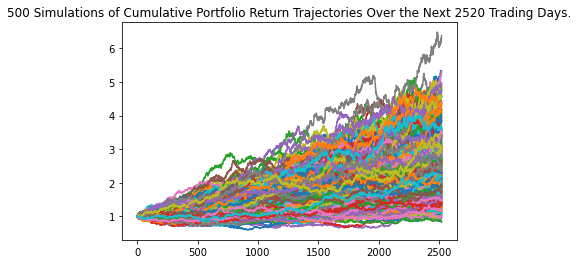

In [42]:
# Plot simulation outcomes
line_plot = MC_tenyears.plot_simulation()
line_plot.get_figure().savefig("MC_tenyear_sim_plot.png", bbox_inches="tight")

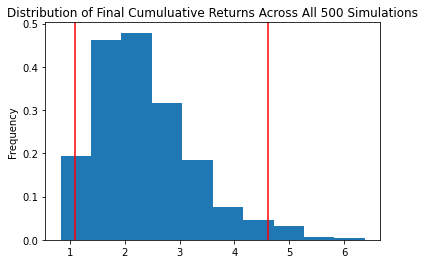

In [43]:
# Plot probability distribution and confidence intervals
dist_plot = MC_tenyears.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_tenyear_dist_plot.png',bbox_inches='tight')

In [44]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_cumulative_return = MC_tenyears.summarize_cumulative_return()

# Print summary statistics
print(tbl_cumulative_return)

count           500.000000
mean              2.371624
std               0.887706
min               0.828684
25%               1.754159
50%               2.230295
75%               2.858279
max               6.381410
95% CI Lower      1.085351
95% CI Upper      4.606123
Name: 2520, dtype: float64


In [45]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_ten = round(MC_tenyears.confidence_interval.iloc[0] * initial_investment, 2)
ci_upper_ten = round(MC_tenyears.confidence_interval.iloc[1] * initial_investment, 2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten:,} and ${ci_upper_ten:,}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $21,707.03 and $92,122.45
